In [26]:
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from pathlib import Path

from cuml.neighbors import NearestNeighbors
from gensim.models.doc2vec import Doc2Vec
from kneed import KneeLocator

In [7]:
data_dir = Path(f'../data/interim')
model_dir = Path(f'../models')
nn_dir = Path(f'data/interim/nn')

In [10]:
paths = [path for path in model_dir.glob('*.model')]


In [16]:
path = paths[1]

In [12]:
filename = paths[0].name
nn_file = Path(nn_dir, f"nn_{'_'.join(paths[0].stem.split('_')[1:])}.npy")

In [13]:
nn_file

PosixPath('data/interim/nn/nn_chains_ge_4_lt_10_50.npy')

In [18]:
model = Doc2Vec.load(str(path))
data = model.dv.vectors.astype(np.float64)

In [23]:
epsilons = np.empty((len(range(3,30)), 2))
counter = 0
for n in range(3,30):
    nearest_neighbors = NearestNeighbors(n_neighbors=n, metric='l2')
    # nearest_neighbors = NearestNeighbors(n_neighbors=n, metric='l2')
    neighbors = nearest_neighbors.fit(data)
    
    distances, indices = neighbors.kneighbors(data)
    distances = np.sort(distances[:, distances.shape[1]-1], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    epsilons[counter][0] = n
    epsilons[counter][1] = distances[knee.knee]
    counter += 1
epsilons

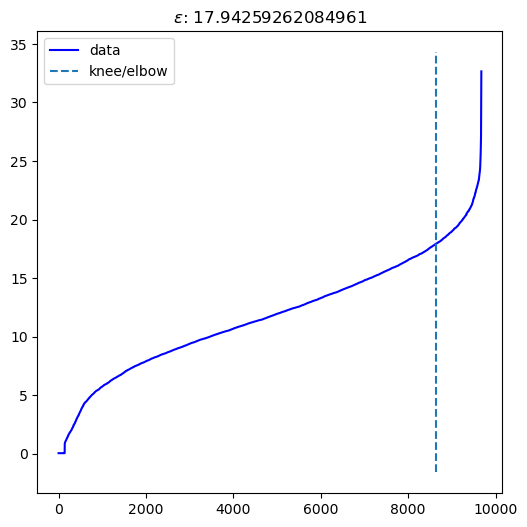

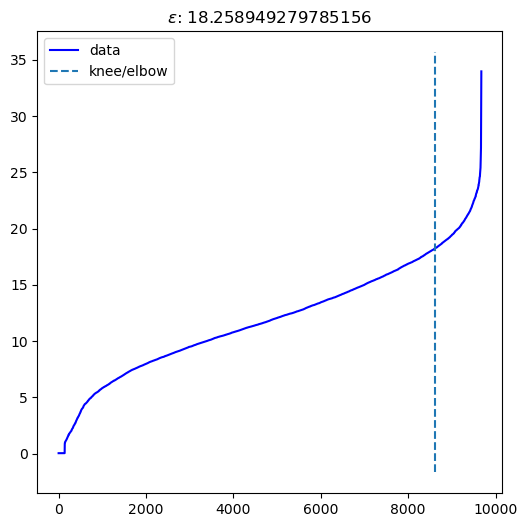

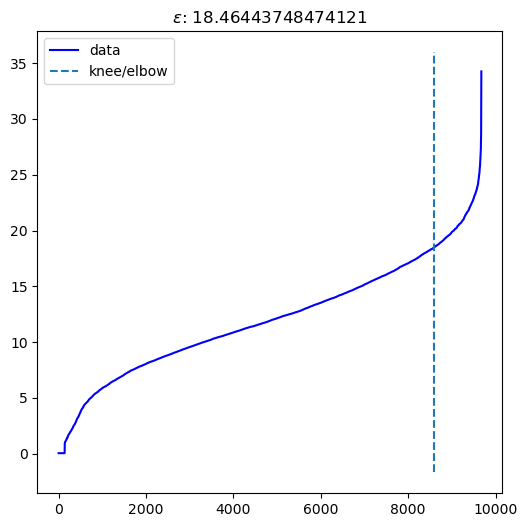

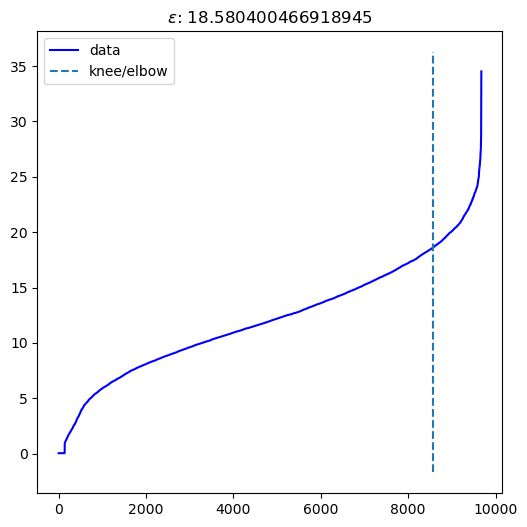

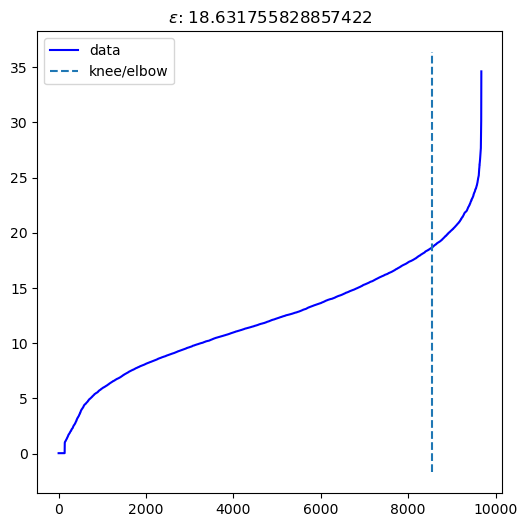

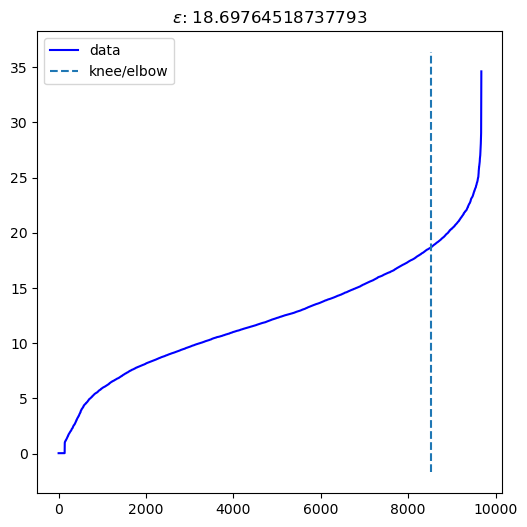

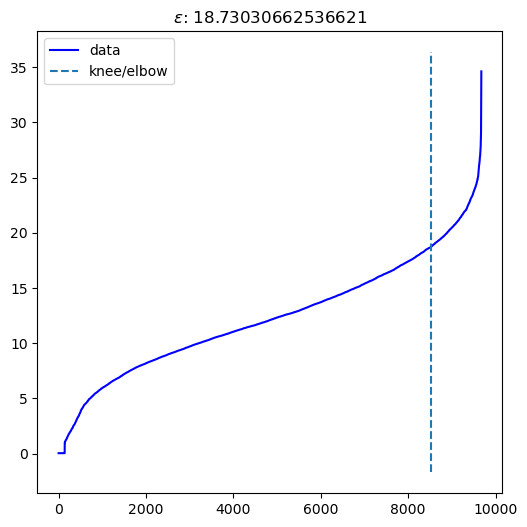

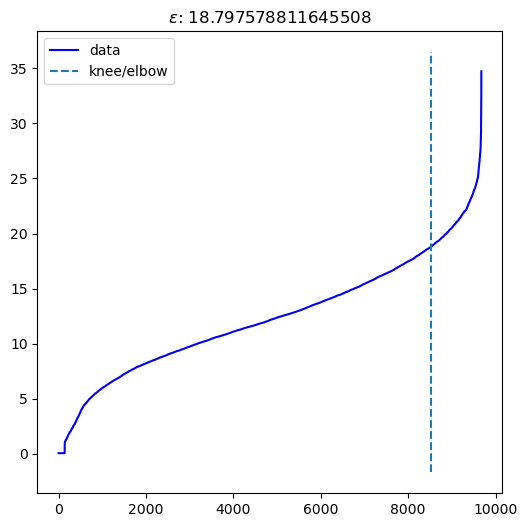

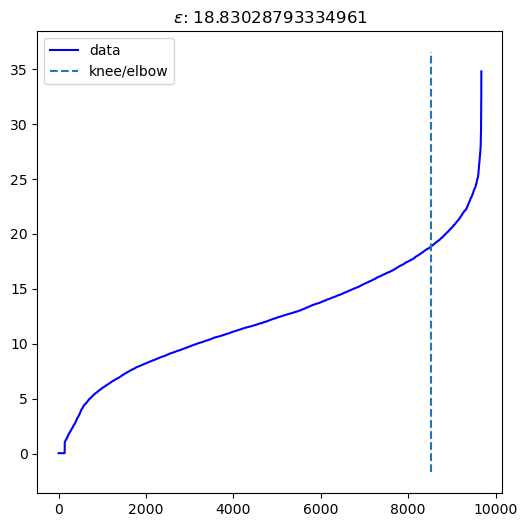

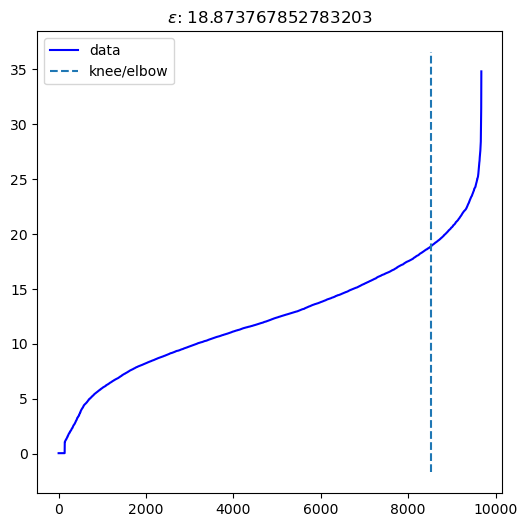

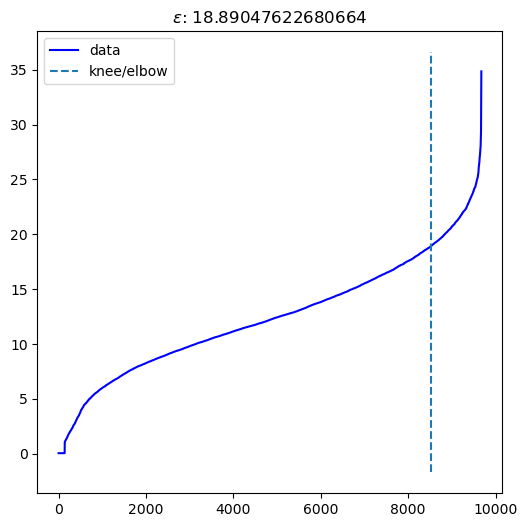

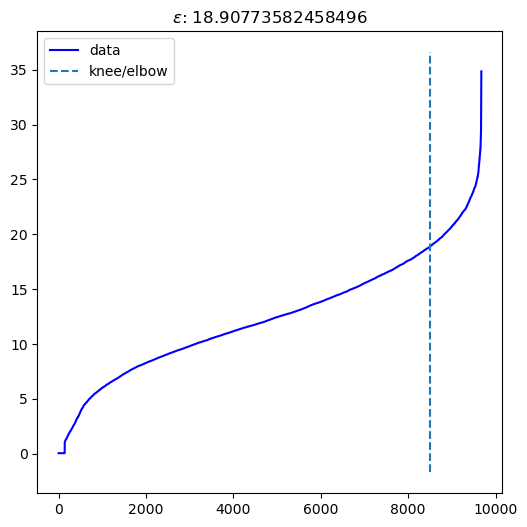

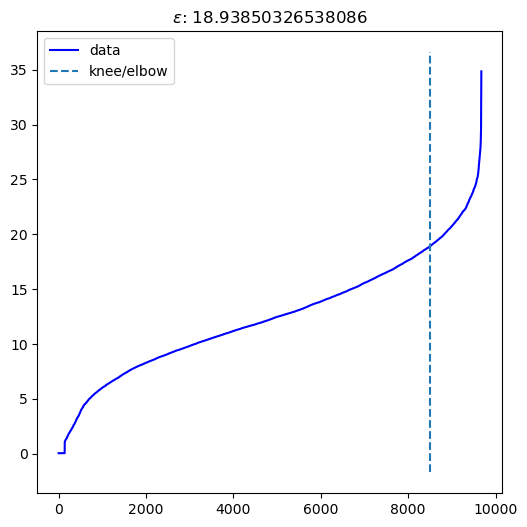

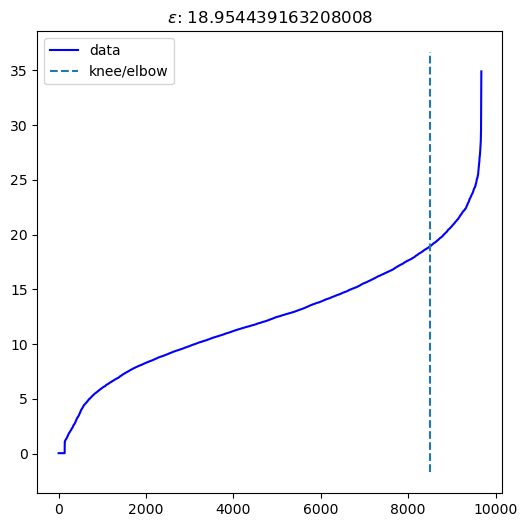

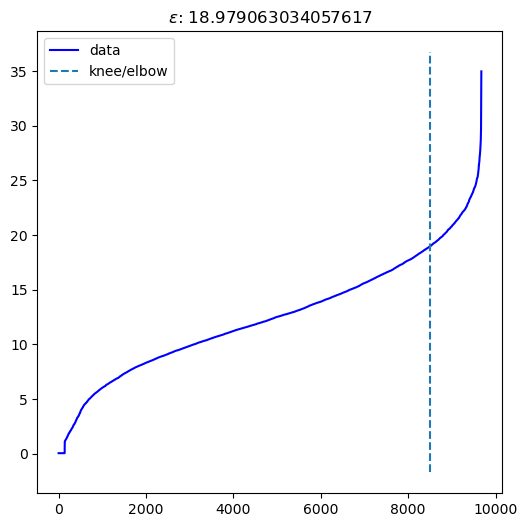

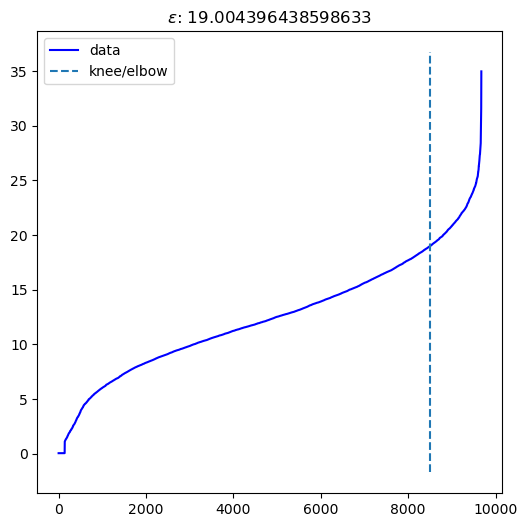

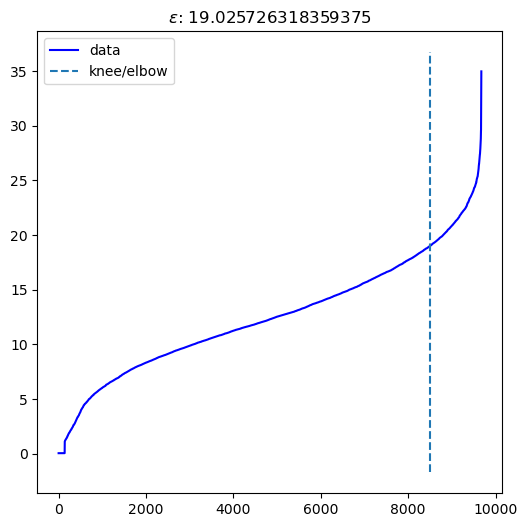

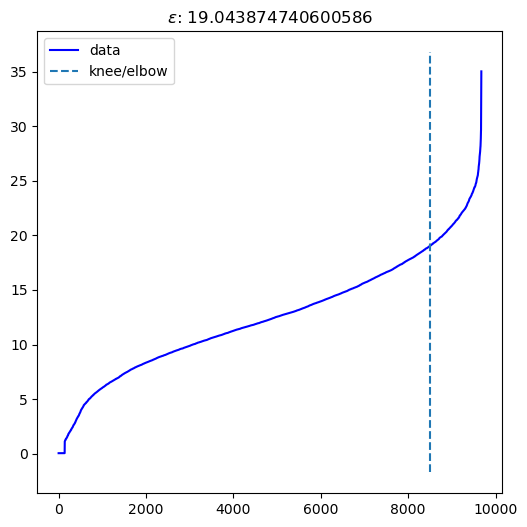

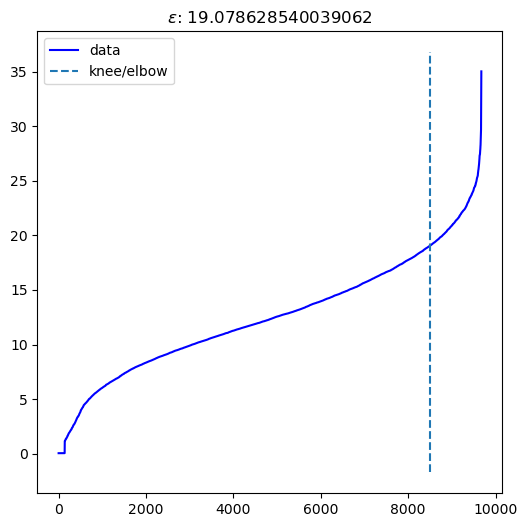

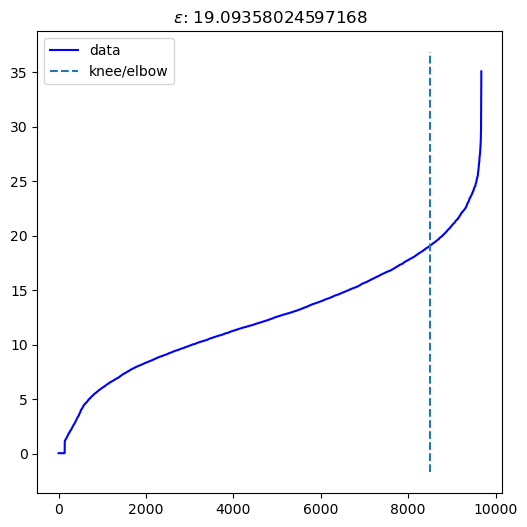

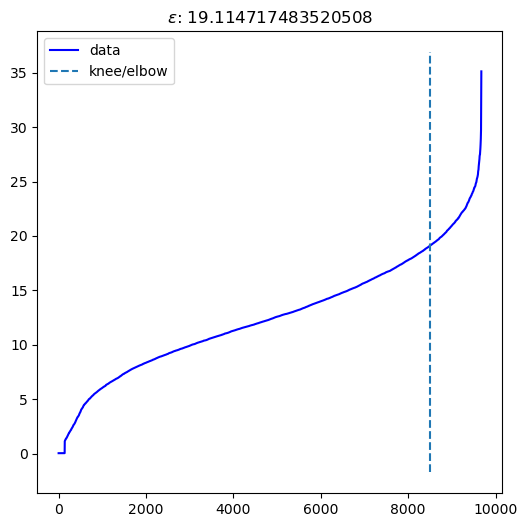

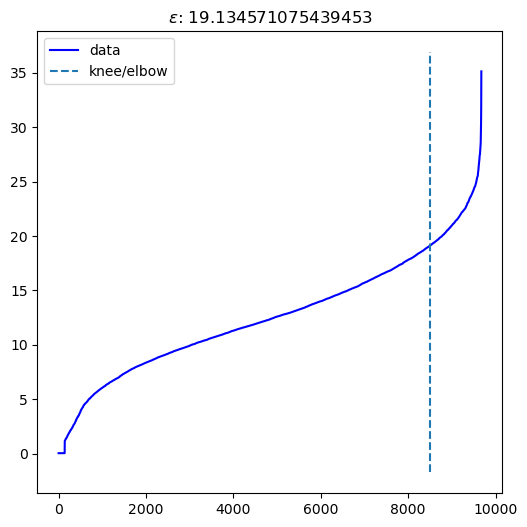

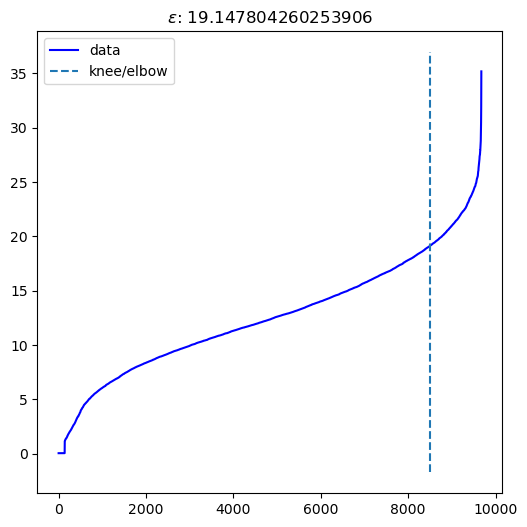

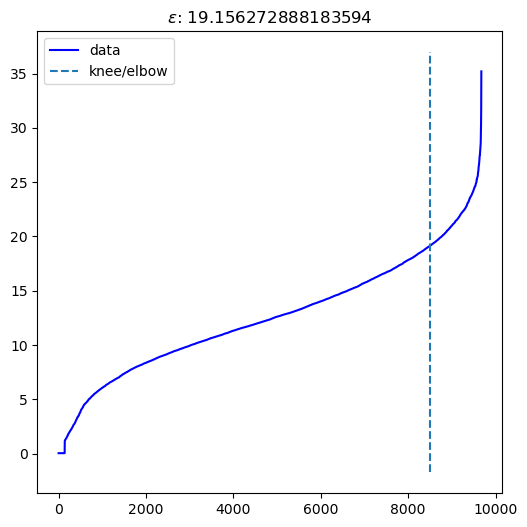

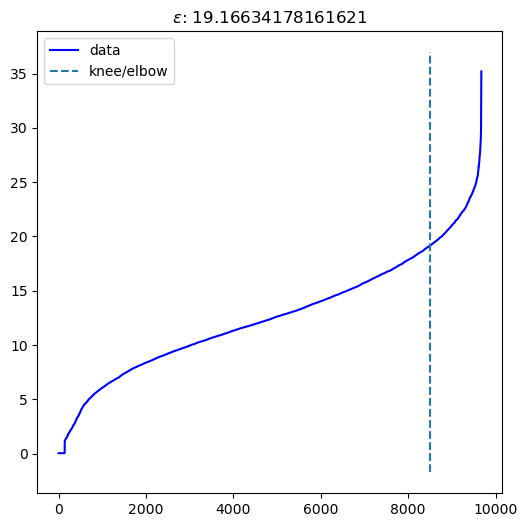

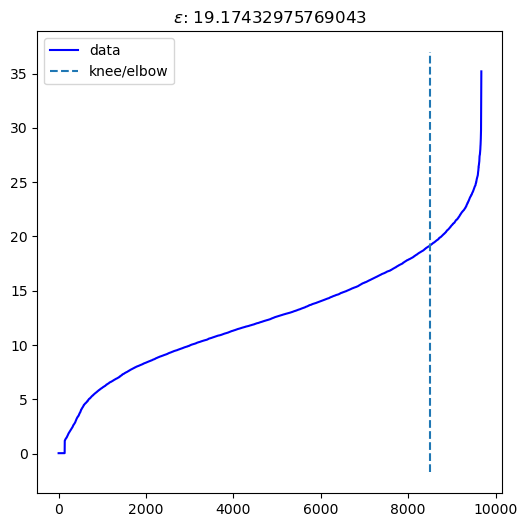

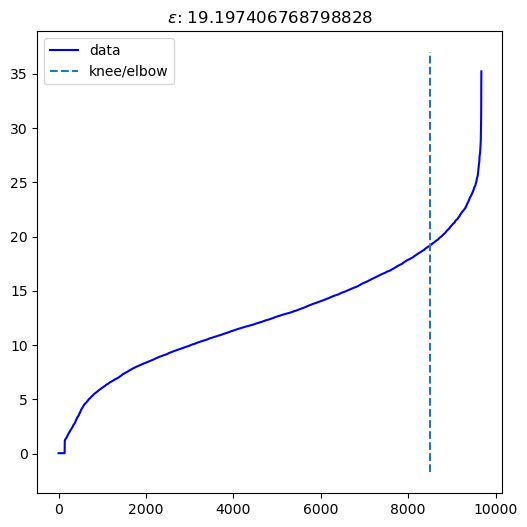

In [31]:
epsilons = np.empty((len(range(3,30)), 2))
counter = 0
for n in range(3,30):
    nearest_neighbors = NearestNeighbors(n_neighbors=n, metric='l2')
    # nearest_neighbors = NearestNeighbors(n_neighbors=n, metric='l2')
    neighbors = nearest_neighbors.fit(data)
    
    distances, indices = neighbors.kneighbors(data)
    distances = np.sort(distances[:, distances.shape[1]-1], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    epsilons[counter][0] = n
    epsilons[counter][1] = distances[knee.knee]
    counter += 1
    
    knee.plot_knee()
    plt.title(fr'$\epsilon$: {distances[knee.knee]}')
    plt.show()

In [24]:
epsilons

array([[ 3.        , 17.94259262],
       [ 4.        , 18.25894928],
       [ 5.        , 18.46443748],
       [ 6.        , 18.58040047],
       [ 7.        , 18.63175583],
       [ 8.        , 18.69764519],
       [ 9.        , 18.73030663],
       [10.        , 18.79757881],
       [11.        , 18.83028793],
       [12.        , 18.87376785],
       [13.        , 18.89047623],
       [14.        , 18.90773582],
       [15.        , 18.93850327],
       [16.        , 18.95443916],
       [17.        , 18.97906303],
       [18.        , 19.00439644],
       [19.        , 19.02572632],
       [20.        , 19.04387474],
       [21.        , 19.07862854],
       [22.        , 19.09358025],
       [23.        , 19.11471748],
       [24.        , 19.13457108],
       [25.        , 19.14780426],
       [26.        , 19.15627289],
       [27.        , 19.16634178],
       [28.        , 19.17432976],
       [29.        , 19.19740677]])

In [25]:
epsilons = np.empty((len(range(3,30)), 2))
counter = 0
for n in range(3,30):
    # nearest_neighbors = NearestNeighbors(n_neighbors=n, metric='l2')
    nearest_neighbors = NearestNeighbors(n_neighbors=n)
    neighbors = nearest_neighbors.fit(data)
    
    distances, indices = neighbors.kneighbors(data)
    distances = np.sort(distances[:, distances.shape[1]-1], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    epsilons[counter][0] = n
    epsilons[counter][1] = distances[knee.knee]
    counter += 1
epsilons

array([[ 3.        , 17.94259262],
       [ 4.        , 18.25894928],
       [ 5.        , 18.46443748],
       [ 6.        , 18.58040047],
       [ 7.        , 18.63175583],
       [ 8.        , 18.69764519],
       [ 9.        , 18.73030663],
       [10.        , 18.79757881],
       [11.        , 18.83028793],
       [12.        , 18.87376785],
       [13.        , 18.89047623],
       [14.        , 18.90773582],
       [15.        , 18.93850327],
       [16.        , 18.95443916],
       [17.        , 18.97906303],
       [18.        , 19.00439644],
       [19.        , 19.02572632],
       [20.        , 19.04387474],
       [21.        , 19.07862854],
       [22.        , 19.09358025],
       [23.        , 19.11471748],
       [24.        , 19.13457108],
       [25.        , 19.14780426],
       [26.        , 19.15627289],
       [27.        , 19.16634178],
       [28.        , 19.17432976],
       [29.        , 19.19740677]])

In [49]:
from cuml.cluster import DBSCAN
from collections import Counter
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score as silscore

In [78]:
for neigh, eps in epsilons:
    for minpts in range(10):
        dbscan_float = DBSCAN(eps = eps, min_samples = minpts)
        dbscan_float.fit(data)
        labels = dbscan_float.labels_
        count_clust = Counter(labels)
        n_clusters = len([key for key in count_clust.keys() if key != -1])

        # points = labels[~labels==-1]
        clust_data = []
        clust_labs = []
        for i, label in enumerate(labels):
            if label != -1:
                clust_data.append(data[i])
                clust_labs.append(labels[i])

        clust_data = np.asarray(clust_data)
        clust_labs = np.asarray(clust_labs)
        
        if n_clusters < 2:
            score = None

        else:
            score = silscore(clust_data, clust_labs)
        print(fr'neighbors {neigh},C clusters: {n_clusters}, eps: {eps}, MinPts: {minpts},  Silhouette Score: {score}')
        

C clusters: 832, eps: 17.94259262084961, MinPts: 0,  Silhouette Score: 0.14796497062904274
C clusters: 832, eps: 17.94259262084961, MinPts: 1,  Silhouette Score: 0.14796497062904274
C clusters: 75, eps: 17.94259262084961, MinPts: 2,  Silhouette Score: 0.22095530193333798
C clusters: 38, eps: 17.94259262084961, MinPts: 3,  Silhouette Score: 0.2411895582283934
C clusters: 20, eps: 17.94259262084961, MinPts: 4,  Silhouette Score: 0.25247484457110125
C clusters: 6, eps: 17.94259262084961, MinPts: 5,  Silhouette Score: 0.27612786403926143
C clusters: 1, eps: 17.94259262084961, MinPts: 6,  Silhouette Score: None
C clusters: 1, eps: 17.94259262084961, MinPts: 7,  Silhouette Score: None
C clusters: 2, eps: 17.94259262084961, MinPts: 8,  Silhouette Score: 0.3116805034335349
C clusters: 1, eps: 17.94259262084961, MinPts: 9,  Silhouette Score: None
C clusters: 719, eps: 18.258949279785156, MinPts: 0,  Silhouette Score: 0.15474674441783015
C clusters: 719, eps: 18.258949279785156, MinPts: 1,  Silh

In [76]:
dbscan_float = DBSCAN(eps = 19.19740677, min_samples = 4)
dbscan_float.fit(data)
labels = dbscan_float.labels_
count_clust = Counter(labels)
n_clusters = len([key for key in count_clust.keys() if key != -1])

# points = labels[~labels==-1]
clust_data = []
clust_labs = []
for i, label in enumerate(labels):
    if label != -1:
        clust_data.append(data[i])
        clust_labs.append(labels[i])

clust_data = np.asarray(clust_data)
clust_labs = np.asarray(clust_labs)
silscore(clust_data, clust_labs)

0.27074493497545216

In [69]:
labels[~labels==-1].shape

(9111,)

In [71]:
clust_data = np.empty(labels[~labels==-1].shape)
clust_labs = np.empty(labels[~labels==-1].shape)

array([4.66095379e-310, 4.66095377e-310, 4.66095379e-310, ...,
       1.18575755e-322, 3.95252517e-323, 2.37151510e-322])

In [74]:
silscore(clust_data, clust_labs) 

0.27074493497545216

In [48]:
count_clust = Counter(labels)
n_clusters = len([key for key in count_clust.keys() if key != -1])
results['n_clusters'] = n_clusters

if -1 in count_clust:
    n_noise = count_clust[-1]
    results['n_noise'] = n_noise

clust_data = []
clust_labs = []
for i, label in enumerate(labels):
    if label != -1:
        clust_data.append(data[i])
        clust_labs.append(labels[i])

Counter({0: 8992,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 4,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 3,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 4,
         26: 2,
         27: 1,
         28: 1,
         29: 2,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 2,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 2,
         57: 5,
         58: 1,
         59: 3,
         60: 1,
         61: 1,
         62: 1,